In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
import re
import os
import math
import json
from pprint import pprint
from pathlib import Path

import redis
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from jfi import jaxm
from pmpc import Problem, solve
from pmpc.experimental.jax.root import all_sensitivity_L
import optax

root_path = Path("").absolute().parents[0]
if str(root_path) not in sys.path:
    sys.path.append(str(root_path))

from src.aslxplane.flight_control.dynamics import fwd_fn, f_fx_fu_fn, params0, dynamics
from src.aslxplane.flight_control.dynamics import int_f_fx_fu_fn2
from src.aslxplane.flight_control.dynamics import fwd_fn2, f_fx_fu_fn2, dynamics2
from src.aslxplane.flight_control.dynamics import nn_fwd_fn, nn_params0
from src.aslxplane.flight_control.dynamics import (
    aero_dynamics,
    aero_fwd_fn,
    aero_params0,
    aero_f_fx_fu_fn,
)
from src.aslxplane.flight_control.lqr import design_LQR_controller, simulate
r = redis.Redis(password=os.environ["REDIS_PASSWORD"])

In [9]:
dyn1 = json.loads(r.get("flight/dynamics_new2").decode("utf8"))
dyn2 = json.loads((Path("") / "data" / "dynamics_new2.json").read_text())

In [11]:
dyn1

{'name': 'f_fx_fu_fn2',
 'params': {'Wu': [[0.6328436605767929,
    0.0022997246683791064,
    0.10296347503088578,
    -0.08365639651574024],
   [-0.6452171128750633,
    -0.005795726380968786,
    -0.011195298853825305,
    0.021837877633682775],
   [0.08130255740244545,
    0.013609983755550377,
    -0.003989363431900857,
    0.025768656160479696],
   [0.41794772214305964,
    -0.004213016488050689,
    -0.009735929108981333,
    0.001103207146705077],
   [0.007151481700205557,
    0.559377885665725,
    0.03748908683169491,
    -0.0006235018987769107],
   [0.019455853461589942,
    -0.047743742681223056,
    0.2213055943682745,
    0.006303639775312753],
   [1.0492571675356164,
    -0.002250574223677609,
    -0.004229165277640952,
    -0.020419456021766653],
   [0.006038353856199286,
    1.3285617484473389,
    0.062237785630483475,
    0.013638747343729045],
   [0.032925967285139746,
    -0.12151023939105765,
    0.7217267879845876,
    0.052122240713640564]],
  'Wx': [[0.25091123

# Second attempt

In [12]:
params0 = params0
params = params0
state = jaxm.randn(11)
control = jaxm.randn(4)
dynamics = dynamics2
fwd_fn = fwd_fn2
f_fx_fu_fn = f_fx_fu_fn2
dynamics(state, control, params0).shape

(11,)

In [13]:
#keys = sorted(r.keys("flight/hist*"))
#keys = sorted(r.keys("flight/new_hist*"))
keys = [b"flight/new_hist0"]
states, controls, stateps = [], [], []
for key in keys:
    hist = json.loads(r.get(key))
    state, control, t = np.array(hist["x"]), np.array(hist["u"]), np.array(hist["t"])
    try:
        idx_start = np.argwhere(state[:, 2] > 20.0)[0][0]
    except:
        continue

    #state1, yaw, state2 = state[:, :7], state[:, 7:8], state[:, 8:]
    #yaw_s, yaw_c = np.sin(yaw), np.cos(yaw)
    #state = np.concatenate([state1, yaw_s, yaw_c, state2], axis=-1)

    state, control = state[idx_start:, :], control[idx_start:, :]
    state, control, statep = state[:-1, :], control[:-1, :], state[1:, :]
    i = int(re.search(r"hist([0-9]+)", key.decode("utf8")).groups()[0])
    if i > 0 or not np.all(state[:, 2] > 20.0):
        continue
    print(key)
    states.append(state)
    controls.append(control)
    stateps.append(statep)
state, control, statep = np.concatenate(states), np.concatenate(controls), np.concatenate(stateps)

b'flight/new_hist0'


In [14]:
opt = optax.adam(1e-2)
opt_state = opt.init(params0)
weights = jaxm.std(state, axis=-2)
print(weights)

@jaxm.jit
def loss(params, state, control, statep):
    Xp_hat = fwd_fn(state, control, params)
    Xp = statep
    #return jaxm.mean(jaxm.sum(optax.huber_loss(Xp_hat, Xp) / weights, axis=-1))
    return jaxm.mean(jaxm.mean((Xp_hat - Xp) ** 2 / weights, axis=-1))

grad_fn = jaxm.jit(jaxm.grad(loss, argnums=0))
update_fn = jaxm.jit(opt.update)
apply_fn = jaxm.jit(optax.apply_updates)

[1.23094902e+03 1.54700578e+03 1.95157077e+02 2.77767987e+00
 3.12806499e+00 9.41699625e-02 1.24238515e-01 3.10134229e-01
 1.82046203e-01 2.03591372e-01 2.10629084e-01]


In [16]:
#params = params0
writer = SummaryWriter()
prng = tqdm(range(int(1e4)))
for it in prng:
    #ridx = np.random.randint(0, state.shape[0], 256)
    #state_, control_, statep_ = state[ridx, :], control[ridx, :], statep[ridx, :]
    state_, control_, statep_ = state, control, statep
    grads = grad_fn(params, state_, control_, statep_)
    grads["dt_sqrt"] = jaxm.zeros(grads["dt_sqrt"].shape)
    updates, opt_state = update_fn(grads, opt_state, grads)
    params = apply_fn(params, updates)
    l = loss(params, state_, control_, statep_)
    writer.add_scalar("loss", float(l), it)
    prng.set_description(f"{l:.4e}")

1.4871e-02: 100%|██████████| 10000/10000 [00:13<00:00, 727.01it/s]


In [7]:
loss(params, state, control, statep)

Array(0.02069337, dtype=float64)

In [24]:
dynamics_obj = {"name": "f_fx_fu_fn2", "params": {k: v.tolist() for (k, v) in params.items()}}
#r.set("flight/dynamics_new2", json.dumps(dynamics_obj))
(Path("") / "data" / "dynamics_new2.json").write_text(json.dumps(dynamics_obj))

2473

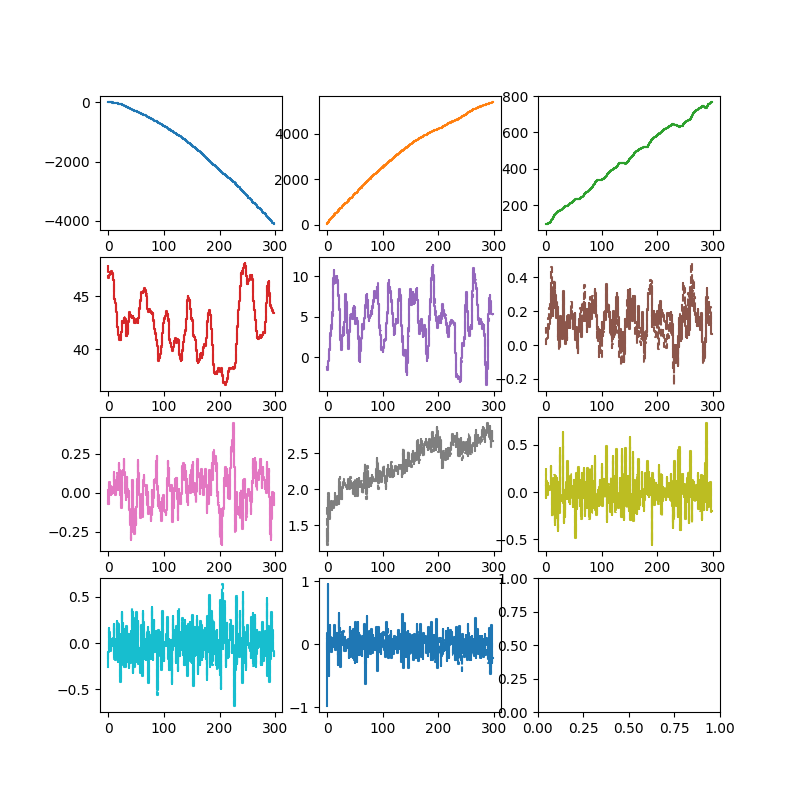

In [8]:
fig, ax = plt.subplots(4, 3, figsize=(8, 8))
ax = ax.reshape(-1)
state_hat = fwd_fn(state, control, params)
for i in range(state.shape[-1]):
    # ax[i].plot((Xp[:, i] - x_mu[i]) / x_std[i], label=f"X[{i}]", color=f"C{i}")
    # ax[i].plot((Xp_hat[:, i] - x_mu[i]) / x_std[i], label=f"X[{i}]", color=f"C{i}", linestyle="--")
    ax[i].step(np.arange(statep.shape[0]), statep[:, i], label=f"X[{i}]", color=f"C{i}")
    ax[i].step(
        np.arange(state_hat.shape[0]),
        state_hat[:, i],
        label=f"X[{i}]",
        color=f"C{i}",
        linestyle="--",
    )
plt.show()


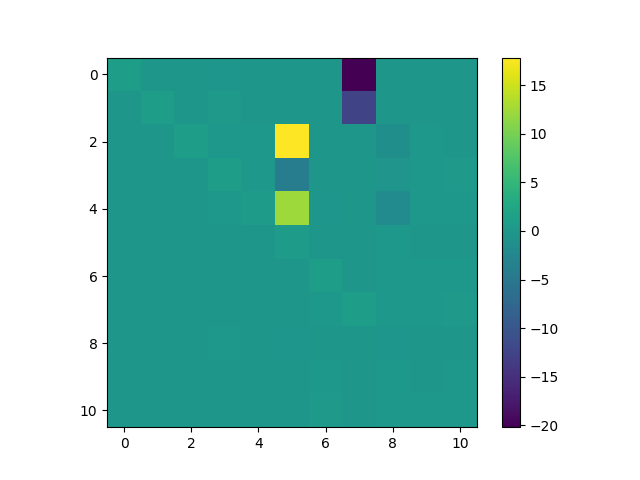

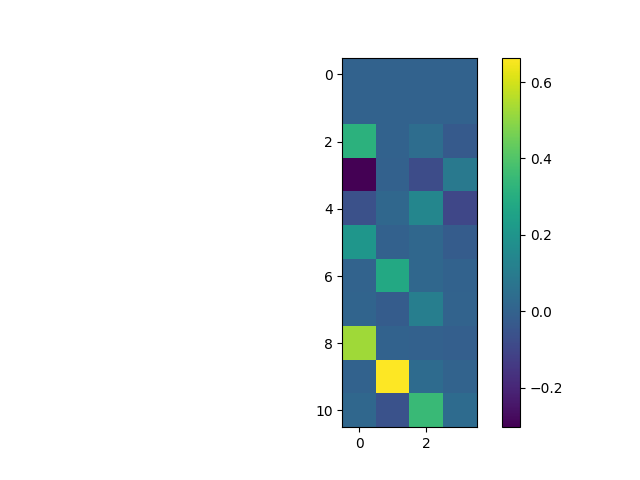

In [12]:
plt.figure()
plt.imshow(f_fx_fu_fn(state, control, params)[1][0])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(f_fx_fu_fn(state, control, params)[2][0])
plt.colorbar()
plt.show()

# Design LQR controller

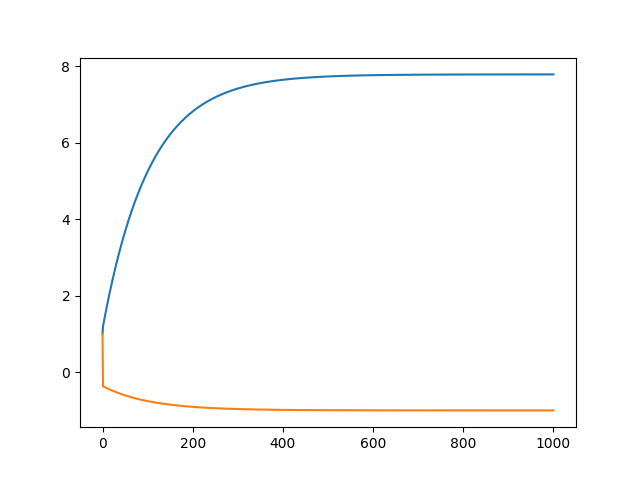

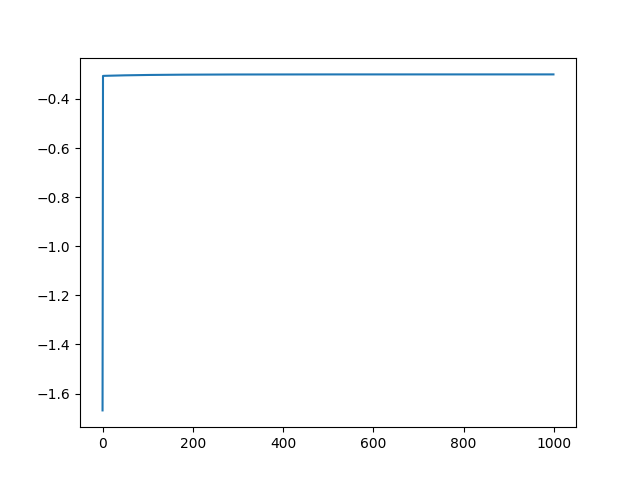

In [135]:
A, B, d = np.array([[1.0, 0.1], [0.0, 1.0]]), np.array([[0.0], [1.0]]), np.array([0.1, 0.3])
Q = np.diag([1.0, 1e2])
R = 1e-2 * np.eye(1)
x_ref = np.array([5.0, 0.0])
u_ref = np.zeros(1)

x0 = np.ones(2)

T = 200
L, l = design_LQR_controller(A, B, d, Q, R, x_ref, u_ref, T=T)
u = L @ x0 + l

xs, us, x = [x0], [], x0
for i in range(1000):
    #L, l = design_LQR_controller(A, B, d, Q, R, x_ref, u_ref, T=T)
    u = L @ x + l
    x = A @ x + B @ u + d
    xs.append(x)
    us.append(u)
plt.figure()
plt.plot(np.stack(xs)[:, 0])
plt.plot(np.stack(xs)[:, 1])
plt.show()
plt.figure()
plt.plot(np.stack(us)[:, 0])
plt.show()

In [244]:
x0 = np.concatenate([state[0, :], np.zeros(6)])
Q = np.diag(
    np.array(
        [1e-3, 1e-3, 1e2]
        + [1e2, 1e-3]
        + [1e-3, 1e3, 1e2]
        + [1e-3, 1e-3, 1e-3]
        + [1e-3, 1e-3, 1e-3]
        + [1e-3, 1e-3, 1e-3]
        #[1e-3, 1e-3, 1e-3]
        #+ [1e1, 1e-3]
        #+ [1e-3, 1e-3, 1e-3]
        #+ [1e-3, 1e-3, 1e-3]
        #+ [1e-3, 1e-3, 1e-3]
        #+ [1e-3, 1e-3, 1e-3]
    )
)
R = np.diag(np.array([1e0, 1e0, 1e3, 1e0])) * 1e2
x_ref = np.copy(x0)
x_ref[3] = 60.0
x_ref[7] = 2.5
u_ref = np.zeros(4)
#u_ref[3] = 1.0
u0 = np.zeros(4)
params["pos_ref"] = x0[:3]
params["ang_ref"] = np.array([0.0, 0.0, x_ref[7]])
f, fx, fu = int_f_fx_fu_fn2(x0, u0, params)
A, B, d = fx, fu, f - fx @ x0 - fu @ u0
T = 30
L, l = design_LQR_controller(A, B, d, Q, R, x_ref, u_ref, T=T)
u = L @ x0 + l

xs, us, x = [x0], [], x0
for i in range(50):
    f, fx, fu = int_f_fx_fu_fn2(x0, u0, params)
    A, B, d = fx, fu, f - fx @ x0 - fu @ u0
    #L, l = design_LQR_controller(A, B, d, Q, R, x_ref, u_ref, T=T)
    u = L @ x + l
    x = int_f_fx_fu_fn2(x, u, params)[0]
    #x = A @ x + B @ u + d
    xs.append(x)
    us.append(u)

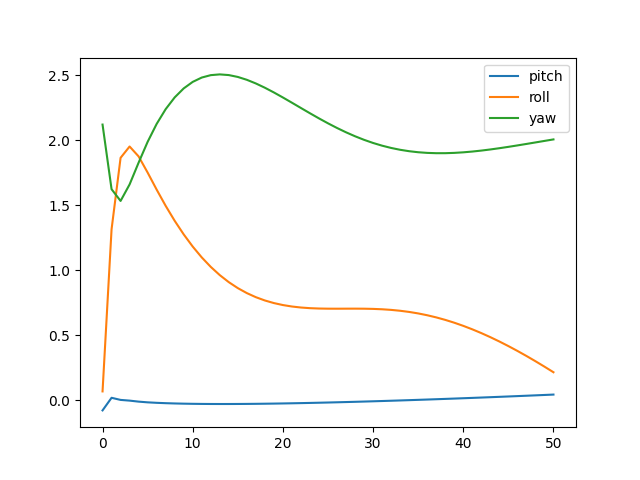

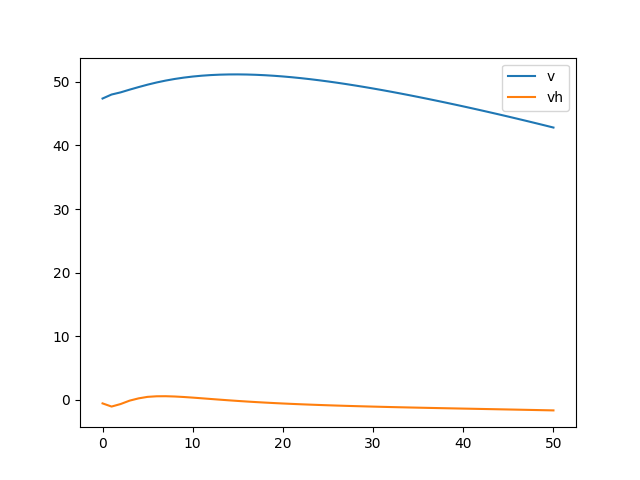

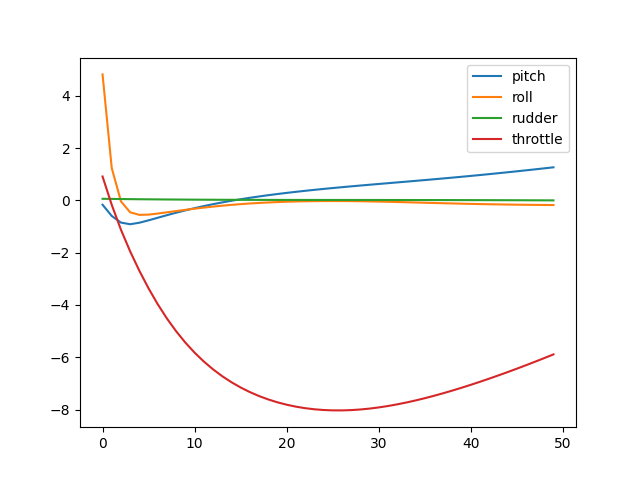

In [245]:
plt.figure()
plt.plot(np.stack(xs)[:, 5], label="pitch")
plt.plot(np.stack(xs)[:, 6], label="roll")
plt.plot(np.stack(xs)[:, 7], label="yaw")
plt.legend()
plt.show()

plt.figure()
plt.plot(np.stack(xs)[:, 3], label="v")
plt.plot(np.stack(xs)[:, 4], label="vh")
plt.legend()
plt.show()

plt.figure()
plt.plot(np.stack(us)[:, 0], label="pitch")
plt.plot(np.stack(us)[:, 1], label="roll")
plt.plot(np.stack(us)[:, 2], label="rudder")
plt.plot(np.stack(us)[:, 3], label="throttle")
plt.legend()
plt.show()

# Fit with Torch

In [4]:
it0 = np.where(X[:, 2] > 30.0)[0][0]
X, U = X[it0:, :], U[it0:, :]
xdim, udim = X.shape[-1], U.shape[-1]
dtype = torch.float64
X, U = torch.as_tensor(X, dtype=dtype), torch.as_tensor(U, dtype=dtype)

A_layer, B_layer = nn.Linear(xdim, xdim, dtype=dtype), nn.Linear(udim, xdim, dtype=dtype)

def fwd_fn(X, U):
    return X + A_layer(X) + B_layer(U)

def loss(X, U):
    X, Xp = X[:-1, :], X[1:, :]
    U = U[:-1, :]
    Xp_hat = fwd_fn(X, U)
    return nn.HuberLoss()(Xp_hat, Xp)

In [24]:
writer = SummaryWriter()
opt = torch.optim.Adam(list(A_layer.parameters()) + list(B_layer.parameters()), lr=1e-3)
for it in range(int(1e5)):
    opt.zero_grad()
    l = loss(X, U)
    l.backward()
    opt.step()
    writer.add_scalar("loss", l.item(), it)

In [25]:
with torch.no_grad():
    Xp_hat = fwd_fn(X, U)[:-1, :]
    Xp = X[1:, :]

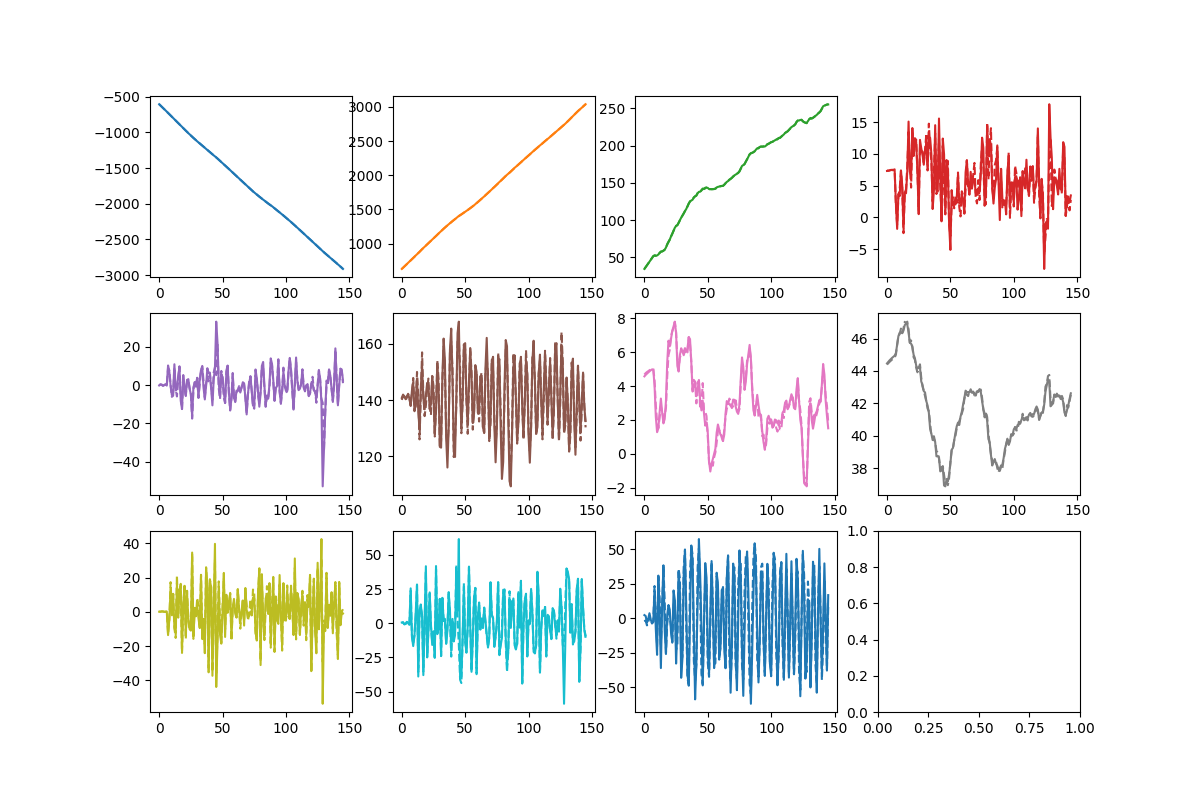

In [26]:
fig, ax = plt.subplots(3, 4, figsize=(12, 8))
ax = ax.reshape(-1)
x_mu, x_std = X.mean(dim=0), X.std(dim=0)
for i in range(xdim):
    #ax[i].plot((Xp[:, i] - x_mu[i]) / x_std[i], label=f"X[{i}]", color=f"C{i}")
    #ax[i].plot((Xp_hat[:, i] - x_mu[i]) / x_std[i], label=f"X[{i}]", color=f"C{i}", linestyle="--")
    ax[i].plot(Xp[:, i], label=f"X[{i}]", color=f"C{i}")
    ax[i].plot(Xp_hat[:, i], label=f"X[{i}]", color=f"C{i}", linestyle="--")
plt.show()

In [37]:
Aw, Ab = A_layer.weight.detach().numpy(), A_layer.bias.detach().numpy()
Bw, Bb = B_layer.weight.detach().numpy(), B_layer.bias.detach().numpy()
r.set(
    "flight/dynamics",
    json.dumps(dict(Aw=Aw.tolist(), Ab=Ab.tolist(), Bw=Bw.tolist(), Bb=Bb.tolist())),
)

Aw, Ab, Bw, Bb = jaxm.array(Aw), jaxm.array(Ab), jaxm.array(Bw), jaxm.array(Bb)

bmv = lambda A, b: (A @ b[..., None])[..., 0]


@jaxm.jit
def f_fn_jax(X, U):
    return X + bmv(Aw, X) + Ab + bmv(Bw, U) + Bb


@jaxm.jit
def fx_fn_jax(X, U):
    return jaxm.tile(jaxm.eye(Aw.shape[-1]) + Aw, (X.shape[:-1]) + (1, 1))


@jaxm.jit
def fu_fn_jax(X, U):
    return jaxm.tile(Bw, X.shape[:-1] + (1, 1))


def f_fx_fu_fn(X, U):
    return f_fn_jax(X, U), fx_fn_jax(X, U), fu_fn_jax(X, U)


In [33]:
X_, U_ = jaxm.array(X), jaxm.array(U)
print(f_fn_jax(X_, U_).shape)
print(fx_fn_jax(X_, U_).shape)
print(fu_fn_jax(X_, U_).shape)

(147, 11)
(147, 11, 11)
(147, 11, 4)


# Optimize resulting dynamics

In [45]:
deg2rad = lambda x: x * np.pi / 180.0
p = Problem(N=10, xdim=11, udim=4)

def fn(x, u, *args):
    f, fx, fu = f_fx_fu_fn(x, u, params)
    return f, fx, fu

p.f_fx_fu_fn = fn
p.x0 = np.array(state[0, :])
p.reg_x, p.reg_u = 1e-3, 1e-3
p.solver_settings = dict(p.solver_settings, solver="mosek")
u_u = np.ones((p.N, p.udim))
u_l = np.concatenate([-np.ones((p.N, p.udim - 1)), np.zeros((p.N, 1))], axis=-1)
p.u_l, p.u_u = u_l, u_u
x_ref = np.copy(p.x0)
x_cost_scale = (
    [1e-3, 1e-3, 1e0]  # position
    + [1e2, 1e2]  # velocities
    + [1e1, 1e4, 1e4]  # angles
    + [1e3, 1e3, 1e3]  # angular rate
)
x_cost_scale = np.array(x_cost_scale) / 1e3
q_diag = x_cost_scale

x_ref[:2] = p.x0[:2]  # positions
x_ref[2] = 100.0  # altitude
x_ref[3:5] = 80.0, 0.0  # velocities
x_ref[5:8] = deg2rad(5.0), 0.0, 1.0  # angles # self.state0[7]
x_ref[8:11] = 0  # dangles

p.X_ref = x_ref
p.X_prev = p.x0
p.U_prev = np.zeros((p.N, p.udim))
p.Q = np.diag(q_diag)

p.R = np.diag(np.array([1e0, 1e0, 1e0, 1e1]))
p.U_ref = np.array([0.0, 0.0, 0.0, 1.0])
p.slew_rate = 1e0

x_l, x_u = -1e5 * np.ones(p.xdim), 1e5 * np.ones(p.xdim)
x_l[2] = 80.0
p.x_l = np.tile(x_l, (p.N, 1))
p.x_u = np.tile(x_u, (p.N, 1))
print(p.x_l.shape)
print(p.x_u.shape)

(10, 11)
(10, 11)


In [46]:
from pmpc.remote import solve_problems
Xs, Us, _ = solve_problems([p])[0]

In [29]:
Xs, Us, _ = solve(**p)

+------+------------+------------+------------+------------+------------+
|  it  |   elaps    |    obj     |   resid    |   reg_x    |   reg_u    |
+------+------------+------------+------------+------------+------------+
| 0001 |  3.375e-03 |  8.352e+01 |  2.764e+02 |  1.000e-03 |  1.000e-03 |
| 0002 |  5.730e-03 |  8.202e+01 |  4.981e+01 |  1.000e-03 |  1.000e-03 |
| 0003 |  8.735e-03 |  8.108e+01 |  2.959e+01 |  1.000e-03 |  1.000e-03 |
| 0004 |  1.198e-02 |  8.059e+01 |  2.307e+01 |  1.000e-03 |  1.000e-03 |
| 0005 |  1.483e-02 |  8.038e+01 |  1.641e+01 |  1.000e-03 |  1.000e-03 |
| 0006 |  1.709e-02 |  8.031e+01 |  1.197e+01 |  1.000e-03 |  1.000e-03 |
| 0007 |  1.895e-02 |  8.031e+01 |  1.015e+01 |  1.000e-03 |  1.000e-03 |
| 0008 |  2.093e-02 |  8.036e+01 |  7.472e-01 |  1.000e-03 |  1.000e-03 |
| 0009 |  2.283e-02 |  8.035e+01 |  8.506e+00 |  1.000e-03 |  1.000e-03 |
| 0010 |  2.464e-02 |  8.040e+01 |  1.894e+00 |  1.000e-03 |  1.000e-03 |
| 0011 |  2.657e-02 |  8.039e+01 |  1.

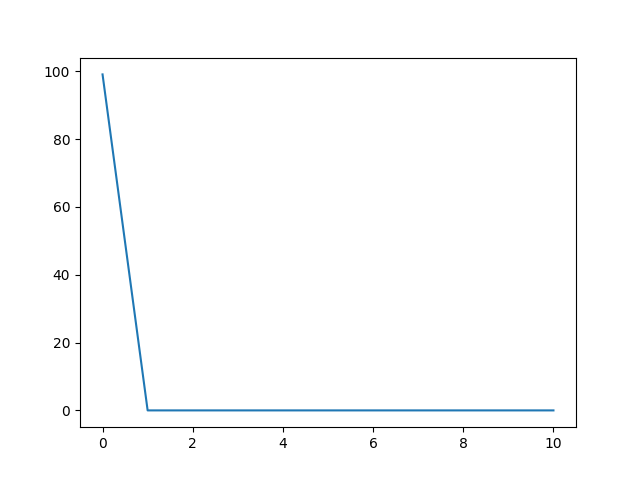

In [44]:
plt.figure()
plt.plot(Xs[:, 2])
plt.show()

In [14]:
L = all_sensitivity_L(Xs, Us, dict(**p))

In [16]:
L[0, :, :]

Array([[ 3.24639512e-07,  2.46903495e-06, -4.10019289e-03,
         5.90157238e-02, -4.66829610e-02, -3.59545433e+00,
        -2.59285309e-02,  8.05098265e-03,  1.31089622e-02,
         2.91696363e-02,  4.96575078e-03,  4.42241694e-02],
       [-3.84633227e-06, -8.22184295e-08, -2.94280093e-05,
         5.05977178e-04, -6.28969744e-04,  6.06461589e-02,
        -1.58668306e+00, -8.74858932e-02, -1.42448359e-01,
        -6.14844127e-03, -1.09266723e-01, -9.56171565e-02],
       [ 3.37494271e-05,  1.49517603e-06,  6.68548023e-05,
         8.10597606e-03, -4.10614410e-04,  2.80038873e-01,
        -6.25773803e-01,  9.87481592e-01,  1.60786074e+00,
        -5.07987664e-02, -5.03301124e-02, -6.40160020e-01],
       [ 3.20469780e-07, -7.78769516e-08, -7.93182547e-05,
        -3.35971038e-03,  7.64243980e-04,  4.44186965e-02,
        -1.02894540e-02,  9.35089243e-03,  1.52255322e-02,
        -1.55888968e-03, -8.68373442e-04, -7.53520660e-03]],      dtype=float64)

In [16]:
L.shape

(10, 4, 12)

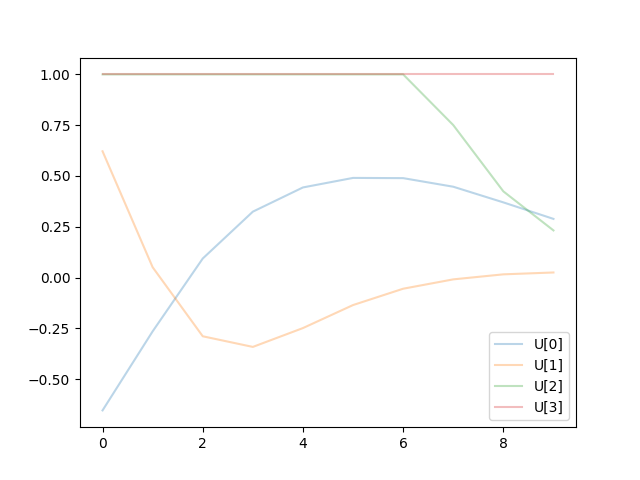

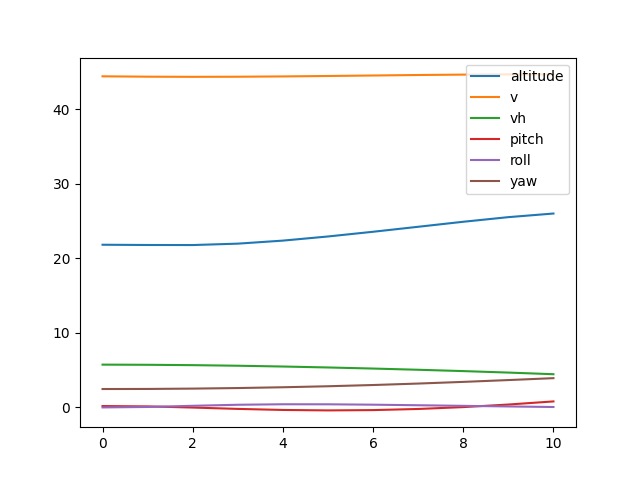

In [32]:
plt.figure()
for r in range(p.udim):
    plt.plot(Us[:, r], label=f"U[{r}]", alpha=0.3)
plt.legend()
plt.show()

plt.figure()
plt.plot(Xs[:, 2], label="altitude")
plt.plot(Xs[:, 3], label="v")
plt.plot(Xs[:, 4], label="vh")
plt.plot(Xs[:, 5], label="pitch")
plt.plot(Xs[:, 6], label="roll")
plt.plot(Xs[:, 7], label="yaw")
plt.legend()
plt.show()

# Initialize velocity

In [41]:
from xpc import XPlaneConnect
from src.aslxplane.flight_control.takeoff import SPEEDS
xp = XPlaneConnect()

In [42]:
posi0 = xp.getPOSI()
vx, vy, vz = map(lambda x: x[0], xp.getDREFs(list(SPEEDS.values())))
v = math.sqrt(vx ** 2 + vz ** 2)
ang = posi0[5] / 180 * math.pi
print(ang)
print(f"vx = {vx}, vy = {vy}, vz = {vz}, v = {v}")
print(f"sin = {math.sin(ang) * v}")
print(f"cos = {math.cos(ang) * v}")

4.359148092344906
vx = -52.12928771972656, vy = -0.06026520952582359, vz = 24.95905113220215, v = 57.79633960369736
sin = -54.22779062225635
cos = -19.994089021874498


In [37]:
np.sin(ang) * v

-55.39576891280695

In [38]:
vz

26.67502212524414